In [48]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from datetime import timedelta
import matplotlib.font_manager as fm
import matplotlib as mpl
import ast
import json
from matplotlib.ticker import FuncFormatter
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

from collections import Counter
# from kiwipiepy import Kiwi

font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
# , fontproperties=font_prop


In [49]:
def read_parquet_from_gcs(file_names, gcs_prefix, key_path):
    dfs = {}
    for name in file_names:
        path = f"{gcs_prefix}/{name}.parquet"
        dfs[name] = pd.read_parquet(path, storage_options={"token": key_path})
    return dfs


file_list = ["hackle_events"]  


gcs_prefix = "gs://sprintda05-yoochang-bucket/hackle"
key_path = "./config/hackle_yoochang.json"

# gcs_prefix = "gs://codeit-project/votes"
# key_path = "./config/key.json"


dfs = read_parquet_from_gcs(file_list, gcs_prefix, key_path)

# # device_properties
# device_properties = dfs["device_properties"]
# hackle_events
hackle_events = dfs["hackle_events"]
# # hackle_properties
# hackle_properties = dfs["hackle_properties"]
# # user_properties
# user_properties = dfs["user_properties"]    

In [50]:
hackle_events.head()

event_id      event_datetime                        event_key                            session_id                                    id item_name page_name  friend_count  votes_count  heart_balance  question_id
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e 2023-07-18 19:40:17                   $session_start          4OzYh3seq3VKytpSn5pvQkZNQii1  00000533-3f1c-4b3b-81f1-0c8f35754b4e                               NaN          NaN            NaN          NaN
1  00000716-27e9-4e72-a602-d0ce61784b06 2023-07-18 21:07:24              click_question_open          8QXy31PQxbW9qLzq0Y1dhR8Ypm52  00000716-27e9-4e72-a602-d0ce61784b06                              64.0        436.0         4830.0          NaN
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc 2023-08-06 20:18:03  click_bottom_navigation_profile  6bcea65d-9f40-46fc-888c-700fe707483f  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc                              26.0        174.0         4729.0          NaN
3  00000981-5e2a-4111-993e-4f1891ad9a53 2023-08-05 01:46:10                        view_shop          XVYNT6zfhFWqIg9omwg2AHDjTLx2  00000981-5e2a-4111-993e-4f1891ad9a53                              61.0         44.0          142.0          NaN
4  00000a7a-ba72-4332-b4a9-7910670aaeb2 2023-07-24 15:03:37      click_bottom_navigation_lab          XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3  00000a7a-ba72-4332-b4a9-7910670aaeb2                             119.0        545.0         3287.0          NaN

In [51]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   event_id        object        
 1   event_datetime  datetime64[ms]
 2   event_key       object        
 3   session_id      object        
 4   id              object        
 5   item_name       object        
 6   page_name       object        
 7   friend_count    float64       
 8   votes_count     float64       
 9   heart_balance   float64       
 10  question_id     float64       
dtypes: datetime64[ms](1), float64(4), object(6)
memory usage: 960.2+ MB


In [52]:
hackle_events.session_id.nunique()

253616

In [53]:
# 1부터 시작하는 정수 인코딩
hackle_events["session_id_encoded"] = (
    hackle_events["session_id"].astype("category").cat.codes + 1
)

In [54]:
hackle_events.head()

event_id      event_datetime                        event_key                            session_id                                    id item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded
0  00000533-3f1c-4b3b-81f1-0c8f35754b4e 2023-07-18 19:40:17                   $session_start          4OzYh3seq3VKytpSn5pvQkZNQii1  00000533-3f1c-4b3b-81f1-0c8f35754b4e                               NaN          NaN            NaN          NaN               31497
1  00000716-27e9-4e72-a602-d0ce61784b06 2023-07-18 21:07:24              click_question_open          8QXy31PQxbW9qLzq0Y1dhR8Ypm52  00000716-27e9-4e72-a602-d0ce61784b06                              64.0        436.0         4830.0          NaN               58874
2  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc 2023-08-06 20:18:03  click_bottom_navigation_profile  6bcea65d-9f40-46fc-888c-700fe707483f  000007c8-68ce-40e6-9b1e-f0e34e8ff9cc                              26.0        174.0         4729.0          NaN               45898
3  00000981-5e2a-4111-993e-4f1891ad9a53 2023-08-05 01:46:10                        view_shop          XVYNT6zfhFWqIg9omwg2AHDjTLx2  00000981-5e2a-4111-993e-4f1891ad9a53                              61.0         44.0          142.0          NaN              155123
4  00000a7a-ba72-4332-b4a9-7910670aaeb2 2023-07-24 15:03:37      click_bottom_navigation_lab          XFB2SPiGfjbVhvJ3Q3DBsaT3m2B3  00000a7a-ba72-4332-b4a9-7910670aaeb2                             119.0        545.0         3287.0          NaN              154275

In [55]:
hackle_events.session_id_encoded.min(), hackle_events.session_id_encoded.max()

(np.int32(1), np.int32(253616))

In [56]:
session_counts = (
    hackle_events.groupby("session_id_encoded")
    .size()
    .reset_index(name="event_count")
)


In [57]:
hackle_events.drop(columns=["session_id"], inplace=True)
hackle_events.drop(columns=["id"], inplace=True)
hackle_events.drop(columns=["event_id"], inplace=True)

In [58]:
session_counts.head()

session_id_encoded  event_count
0                   1            2
1                   2           50
2                   3            2
3                   4            2
4                   5           42

In [59]:
session_counts.describe()

session_id_encoded    event_count
count       253616.000000  253616.000000
mean        126808.500000      45.112765
std          73212.777273     115.665378
min              1.000000       1.000000
25%          63404.750000      10.000000
50%         126808.500000      22.000000
75%         190212.250000      45.000000
max         253616.000000    8157.000000

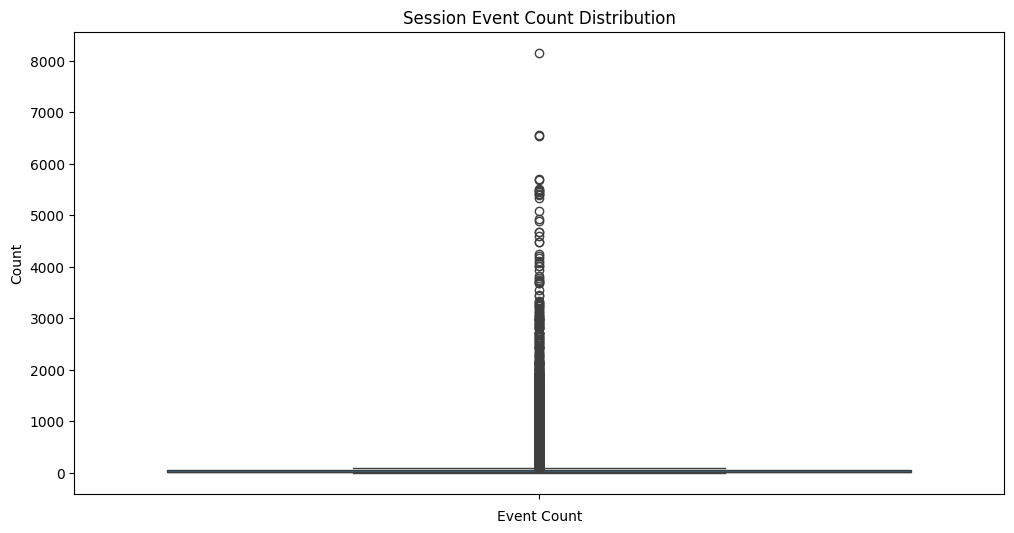

In [60]:
plt.figure(figsize=(12, 6))
sns.boxplot(session_counts["event_count"])
plt.title("Session Event Count Distribution")
plt.xlabel("Event Count")
plt.ylabel("Count")
plt.show()

### 뭘 볼 수 있을까?

In [61]:
hackle_events.describe()

event_datetime  friend_count   votes_count  heart_balance    question_id  session_id_encoded
count                    11441319  1.068876e+07  1.068676e+07   1.071268e+07  449484.000000        1.144132e+07
mean   2023-07-29 01:58:17.236000  5.434357e+01  2.572742e+02   1.626929e+04    2766.385262        1.193410e+05
min           2023-07-18 00:00:00  0.000000e+00  0.000000e+00   0.000000e+00      99.000000        1.000000e+00
25%           2023-07-22 21:31:17  3.200000e+01  9.700000e+01   4.340000e+02    1393.000000        5.319100e+04
50%           2023-07-28 17:08:58  4.900000e+01  2.100000e+02   1.249000e+03    2569.000000        1.155780e+05
75%           2023-08-04 17:59:10  7.100000e+01  3.620000e+02   3.188000e+03    4459.000000        1.826260e+05
max           2023-08-10 23:59:59  1.365000e+03  3.017000e+03   8.849998e+08    5133.000000        2.536160e+05
std                           NaN  3.350798e+01  2.180682e+02   3.317340e+06    1599.967343        7.390297e+04

In [62]:
hackle_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11441319 entries, 0 to 11441318
Data columns (total 9 columns):
 #   Column              Dtype         
---  ------              -----         
 0   event_datetime      datetime64[ms]
 1   event_key           object        
 2   item_name           object        
 3   page_name           object        
 4   friend_count        float64       
 5   votes_count         float64       
 6   heart_balance       float64       
 7   question_id         float64       
 8   session_id_encoded  int32         
dtypes: datetime64[ms](1), float64(4), int32(1), object(3)
memory usage: 742.0+ MB


In [63]:
hackle_events['votes_count'].describe().round(2)

count    10686765.00
mean          257.27
std           218.07
min             0.00
25%            97.00
50%           210.00
75%           362.00
max          3017.00
Name: votes_count, dtype: float64

In [64]:
hackle_events.event_key.value_counts()

event_key
view_lab_tap                         1266665
view_timeline_tap                    1194508
$session_start                       1036852
launch_app                            986388
click_question_open                   816801
click_bottom_navigation_questions     769163
click_bottom_navigation_profile       653507
$session_end                          649658
click_bottom_navigation_timeline      536051
skip_question                         454981
click_bottom_navigation_lab           453683
view_profile_tap                      413294
view_questions_tap                    353400
click_appbar_alarm_center             253541
click_notice_detail                   229358
click_question_start                  220385
click_random_ask_shuffle              184217
click_attendance                      157737
complete_question                     154105
click_appbar_chat_rooms               148422
click_question_ask                    136766
click_question_share                   69241


In [65]:
hackle_events.head()

event_datetime                        event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded
0 2023-07-18 19:40:17                   $session_start                               NaN          NaN            NaN          NaN               31497
1 2023-07-18 21:07:24              click_question_open                              64.0        436.0         4830.0          NaN               58874
2 2023-08-06 20:18:03  click_bottom_navigation_profile                              26.0        174.0         4729.0          NaN               45898
3 2023-08-05 01:46:10                        view_shop                              61.0         44.0          142.0          NaN              155123
4 2023-07-24 15:03:37      click_bottom_navigation_lab                             119.0        545.0         3287.0          NaN              154275

In [66]:
hackle_events.describe()

event_datetime  friend_count   votes_count  heart_balance    question_id  session_id_encoded
count                    11441319  1.068876e+07  1.068676e+07   1.071268e+07  449484.000000        1.144132e+07
mean   2023-07-29 01:58:17.236000  5.434357e+01  2.572742e+02   1.626929e+04    2766.385262        1.193410e+05
min           2023-07-18 00:00:00  0.000000e+00  0.000000e+00   0.000000e+00      99.000000        1.000000e+00
25%           2023-07-22 21:31:17  3.200000e+01  9.700000e+01   4.340000e+02    1393.000000        5.319100e+04
50%           2023-07-28 17:08:58  4.900000e+01  2.100000e+02   1.249000e+03    2569.000000        1.155780e+05
75%           2023-08-04 17:59:10  7.100000e+01  3.620000e+02   3.188000e+03    4459.000000        1.826260e+05
max           2023-08-10 23:59:59  1.365000e+03  3.017000e+03   8.849998e+08    5133.000000        2.536160e+05
std                           NaN  3.350798e+01  2.180682e+02   3.317340e+06    1599.967343        7.390297e+04

In [67]:
hackle_events[hackle_events['session_id_encoded'] == 5].sort_values(by = 'event_datetime', ascending = True)

event_datetime                          event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded
6348215  2023-07-26 18:53:38                         launch_app                               NaN          NaN            NaN          NaN                   5
10572829 2023-07-26 18:53:38                     $session_start                               NaN          NaN            NaN          NaN                   5
9295991  2023-07-26 18:53:40                      view_home_tap                               NaN          NaN            NaN          NaN                   5
3884398  2023-07-26 18:53:57                       $session_end                               NaN          NaN            NaN          NaN                   5
5481371  2023-07-26 18:53:57                         launch_app                               NaN          NaN            NaN          NaN                   5
8718871  2023-07-26 18:54:00                     $session_start                               NaN          NaN            NaN          NaN                   5
3764278  2023-07-26 18:54:02          click_appbar_alarm_center                              56.0        165.0         1262.0          NaN                   5
10227263 2023-07-26 18:54:07  click_bottom_navigation_questions                              56.0        165.0         1262.0          NaN                   5
3747460  2023-07-26 18:54:07  click_bottom_navigation_questions                              56.0        165.0         1262.0          NaN                   5
1617743  2023-07-26 18:54:08  click_bottom_navigation_questions                              56.0        165.0         1262.0          NaN                   5
5516266  2023-07-26 18:54:08                  view_timeline_tap                              56.0        165.0         1262.0          NaN                   5
7308377  2023-07-26 18:54:12                       view_lab_tap                              56.0        165.0         1262.0          NaN                   5
8832185  2023-07-26 18:54:14                   view_profile_tap                              56.0        165.0         1262.0          NaN                   5
8012398  2023-07-26 18:54:32                  view_timeline_tap                              56.0        165.0         1262.0          NaN                   5
703585   2023-07-26 18:54:32                 view_questions_tap                              56.0        165.0         1262.0          NaN                   5
6647252  2023-07-26 18:54:32                       view_lab_tap                              56.0        165.0         1262.0          NaN                   5
9998775  2023-07-26 18:54:32  click_bottom_navigation_questions                              56.0        165.0         1262.0          NaN                   5
7010974  2023-07-26 18:54:33   click_bottom_navigation_timeline                              56.0        165.0         1262.0          NaN                   5
280210   2023-07-26 18:54:33                  view_timeline_tap                              56.0        165.0         1262.0          NaN                   5
1677857  2023-07-26 18:54:34                 view_questions_tap                              56.0        165.0         1262.0          NaN                   5
2676550  2023-07-26 18:54:34  click_bottom_navigation_questions                              56.0        165.0         1262.0          NaN                   5
11222918 2023-07-26 18:54:38        click_bottom_navigation_lab                              56.0        165.0         1262.0          NaN                   5
4853764  2023-07-26 18:54:38                  view_timeline_tap                              56.0        165.0         1262.0          NaN                   5
2918104  2023-07-26 18:54:38                       view_lab_tap                              56.0        165.0         1262.0          NaN                   5
6670399  2023-07-26 18:54:39           

### event_key별 월별 흐름

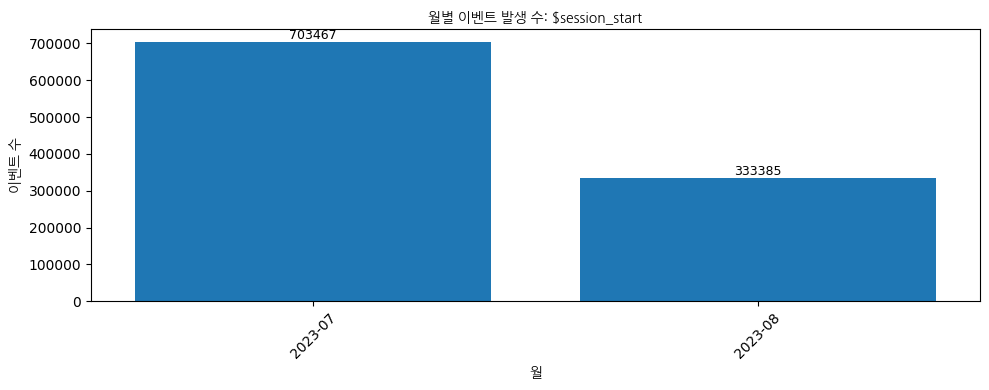

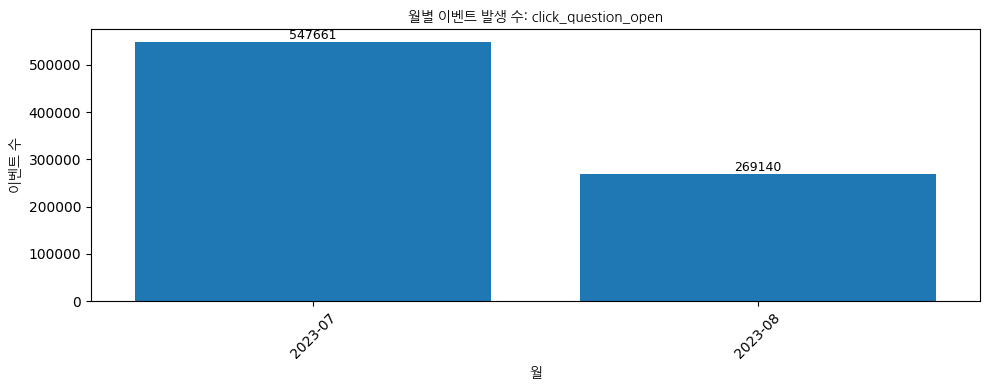

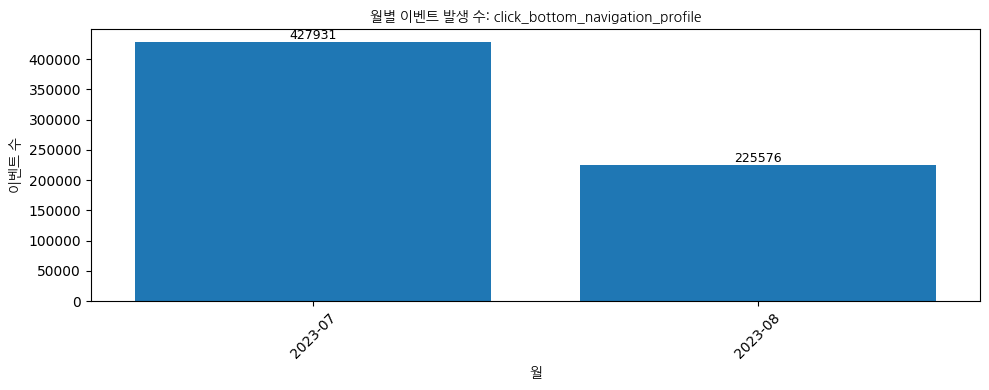

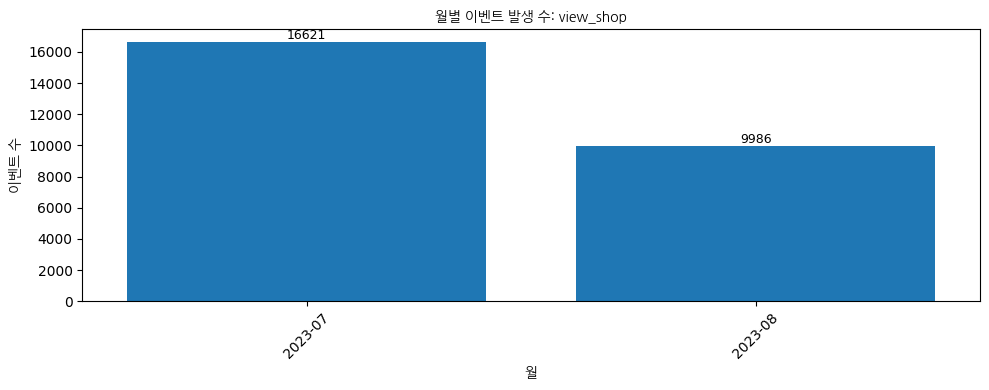

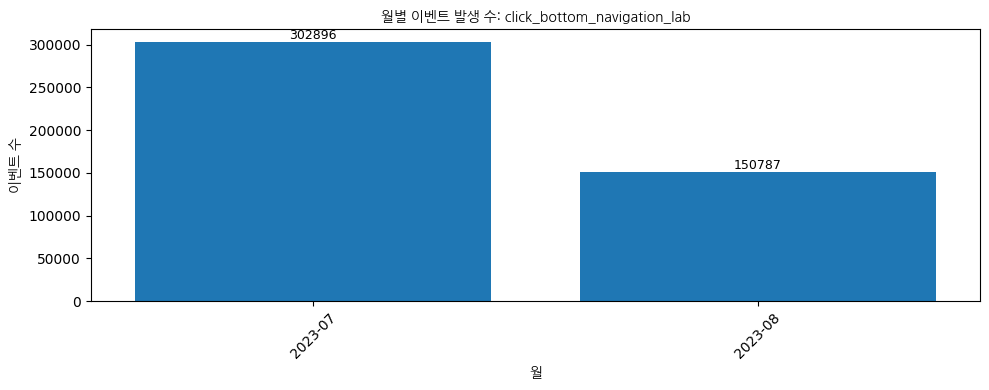

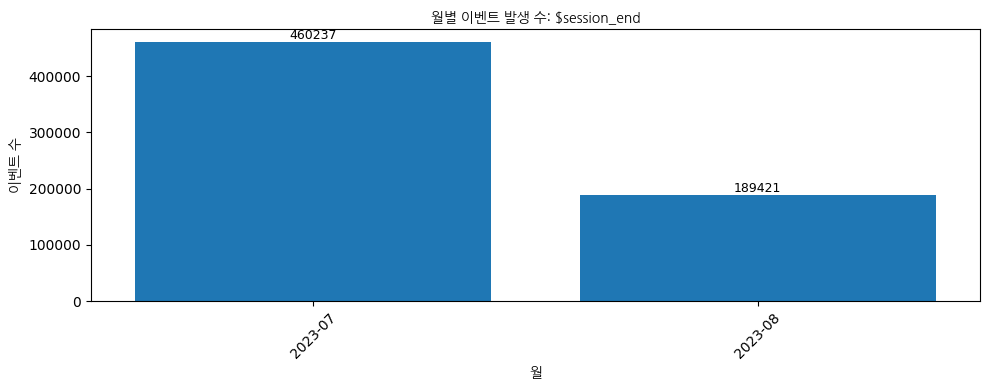

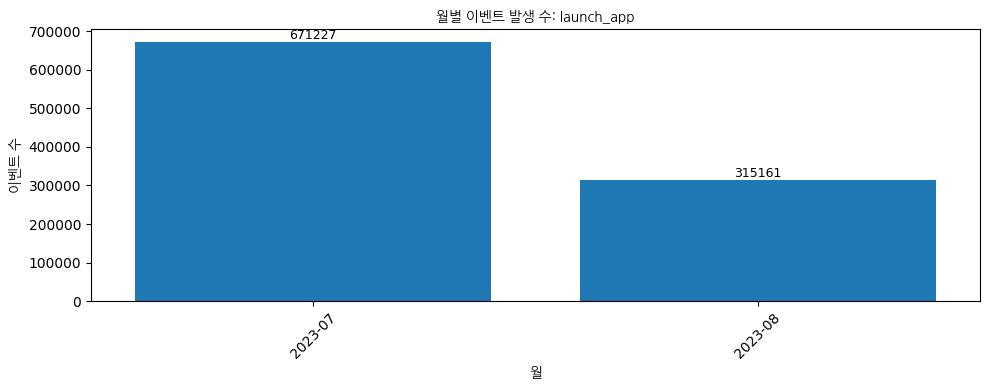

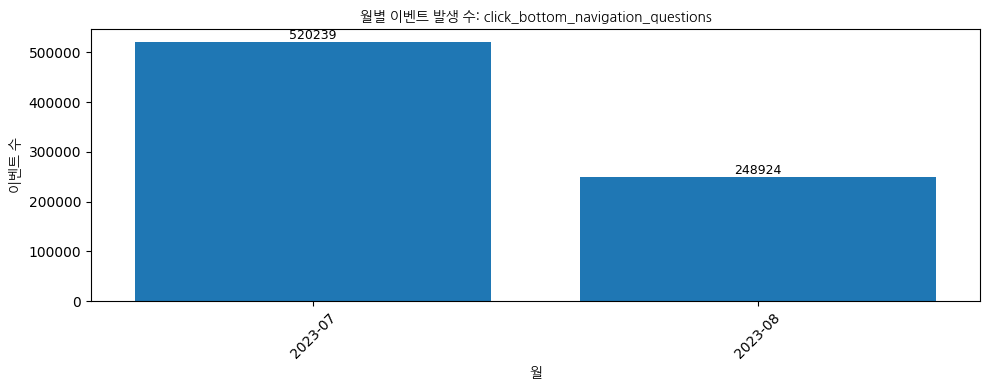

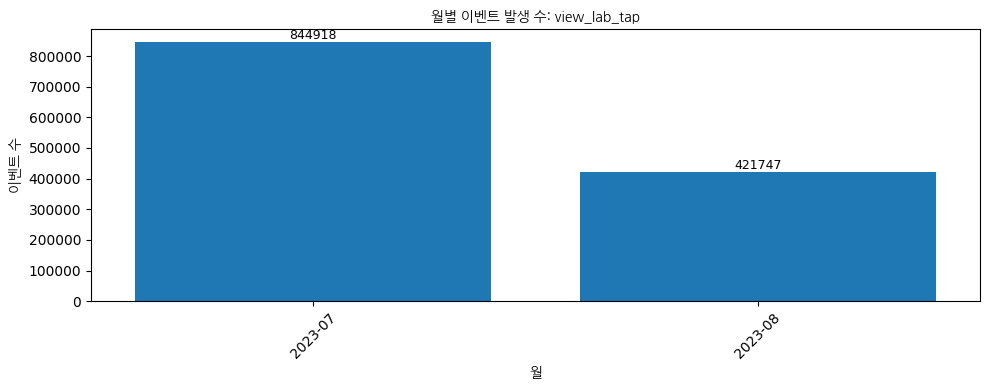

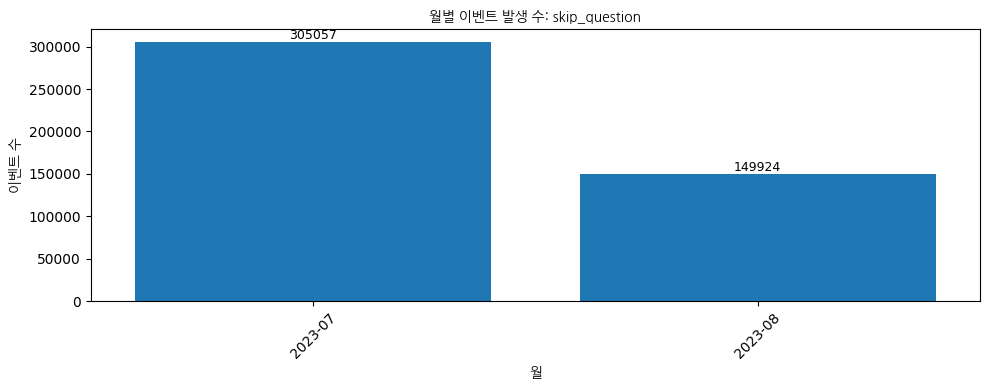

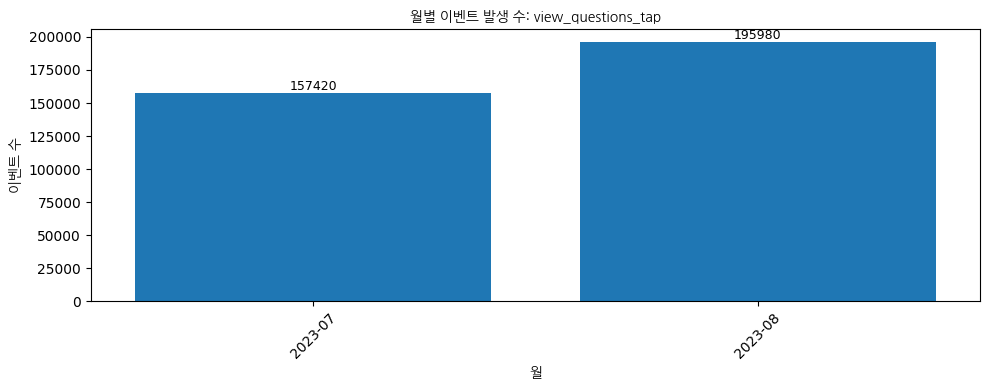

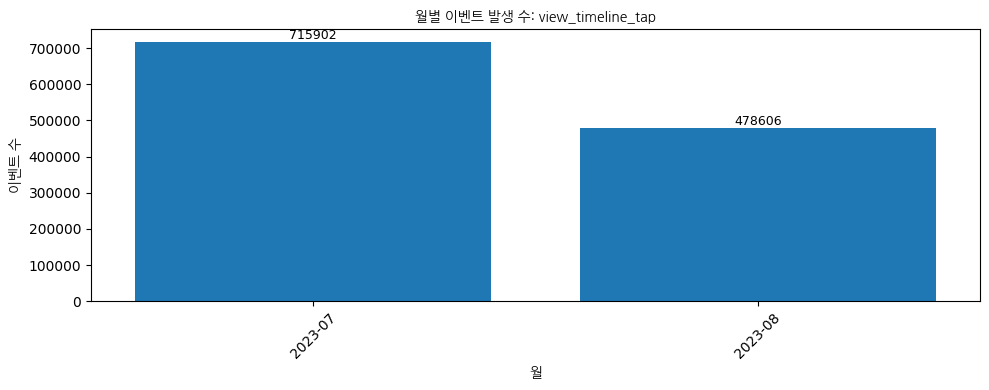

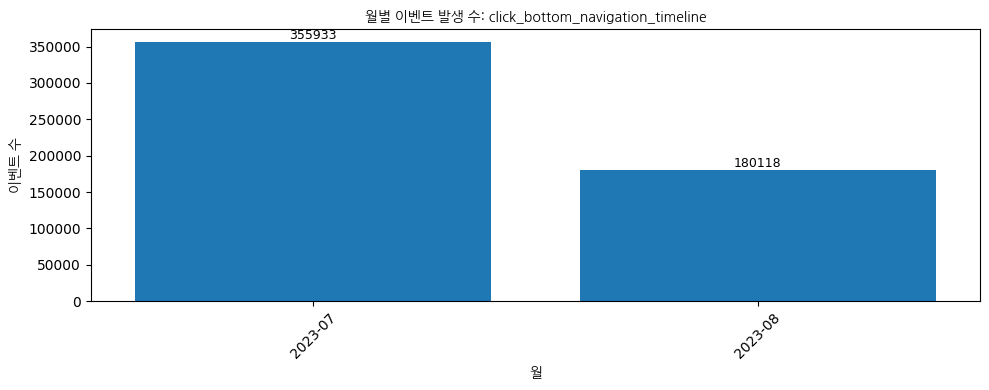

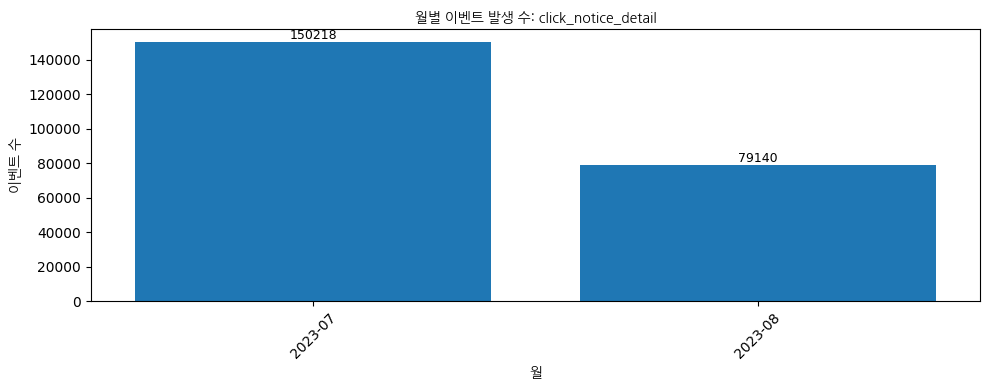

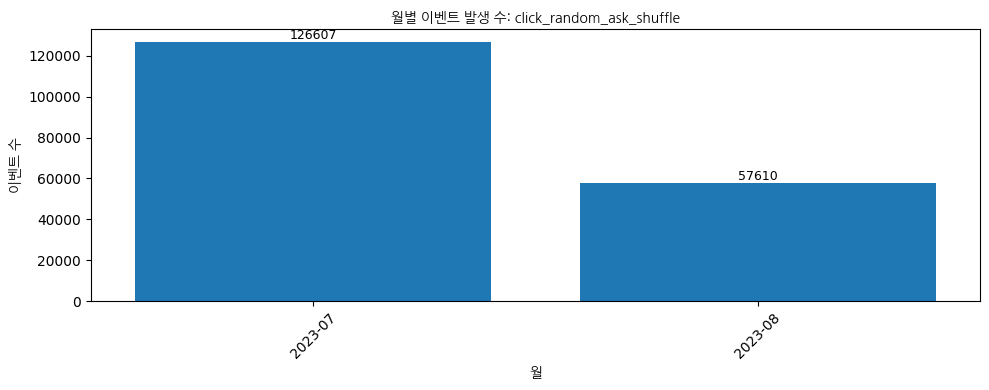

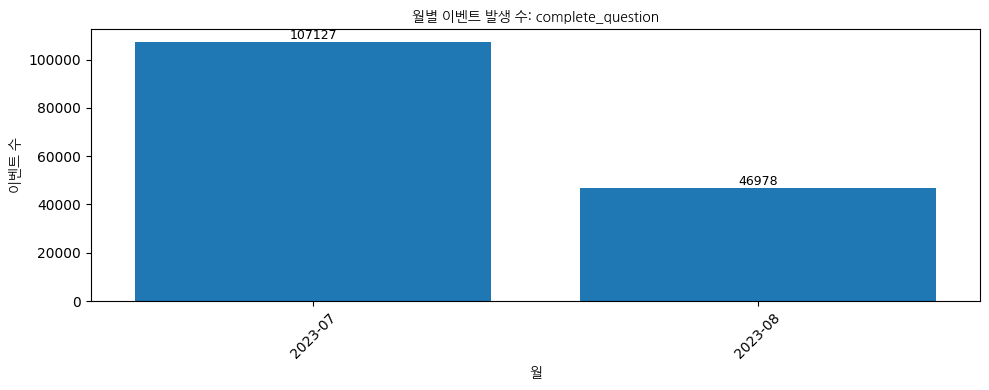

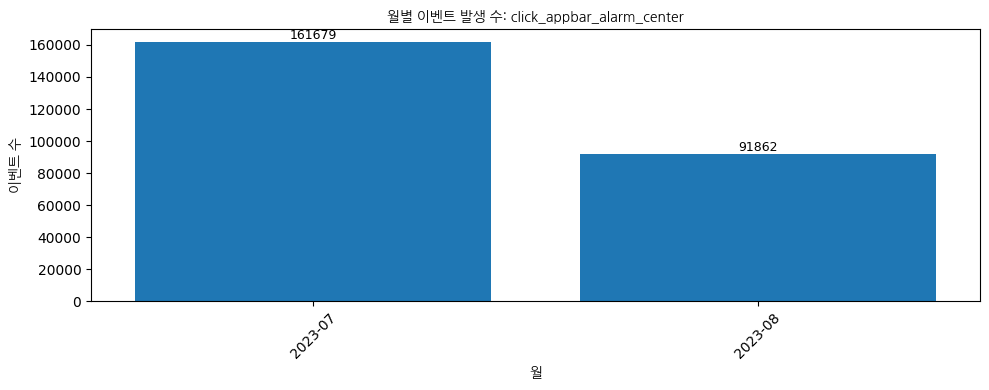

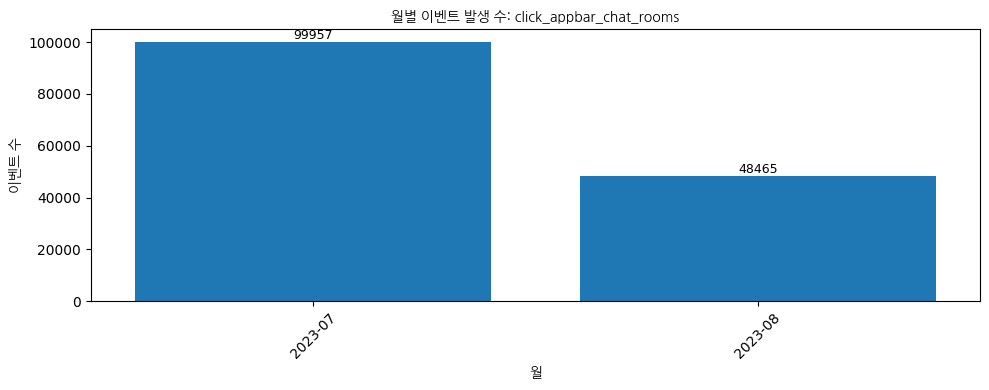

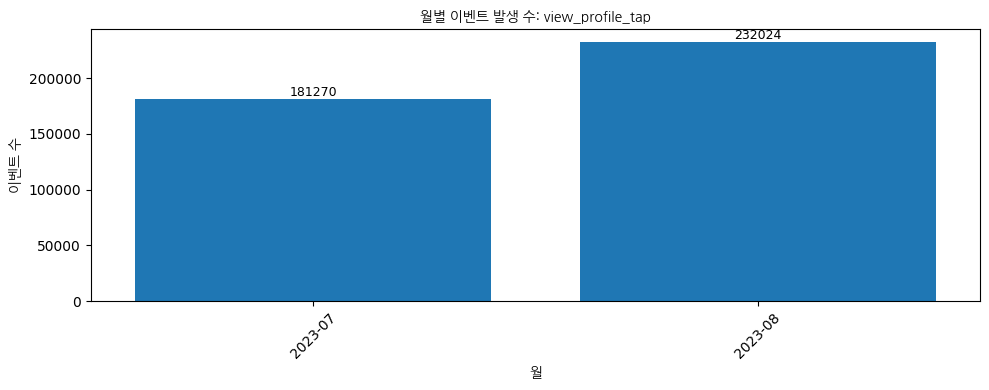

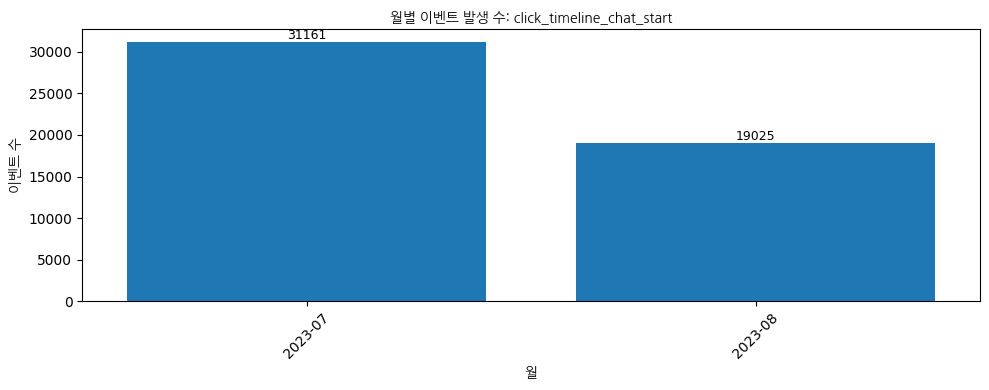

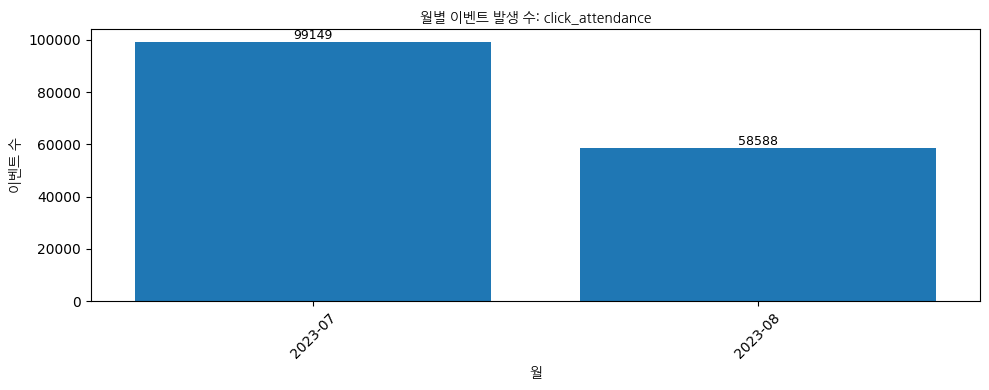

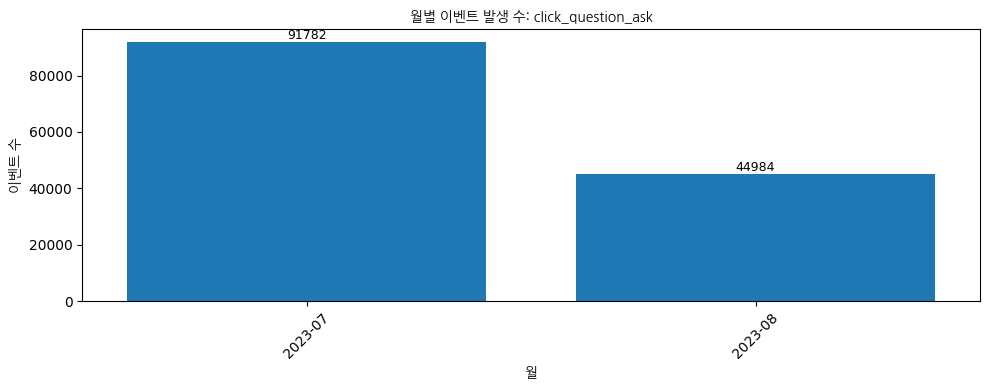

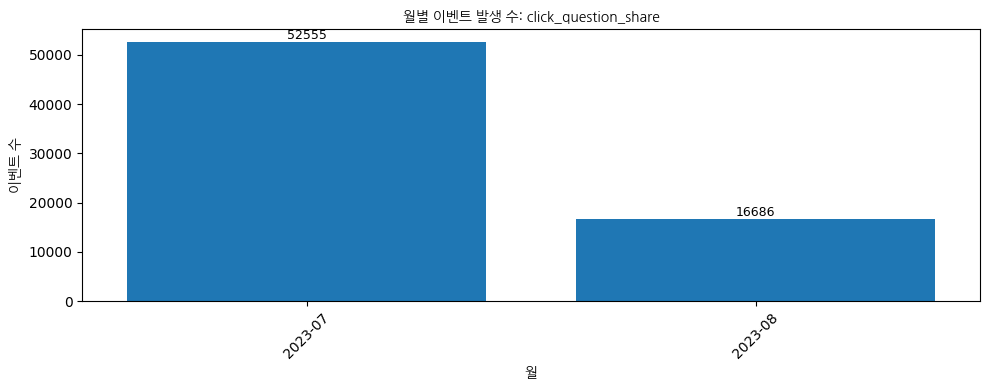

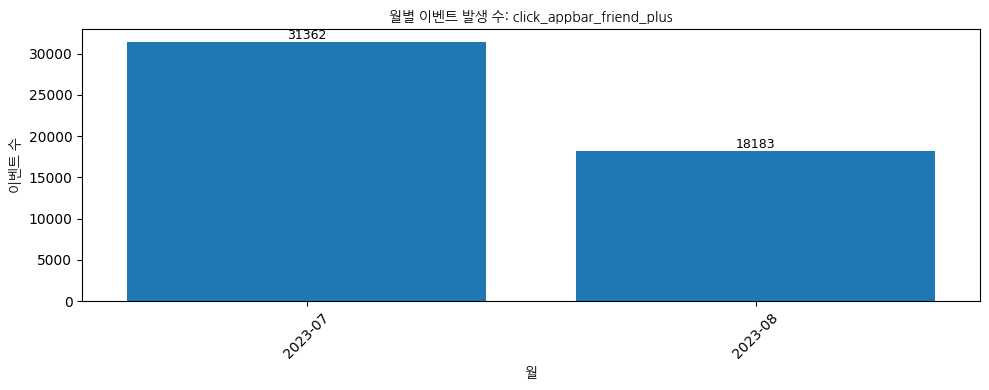

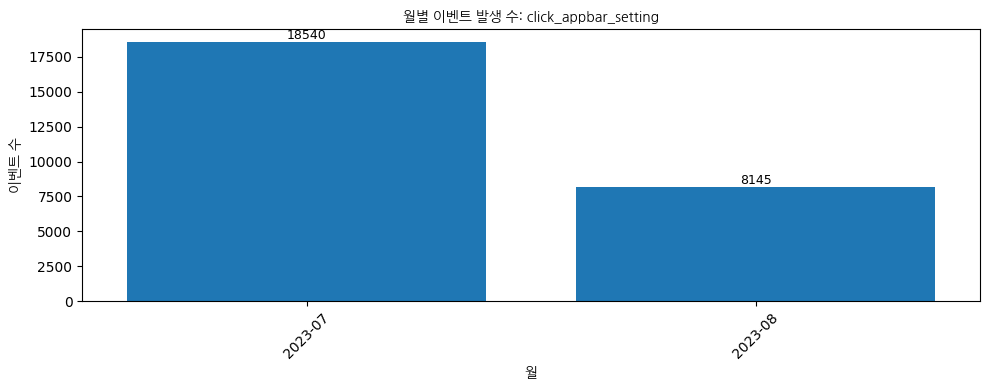

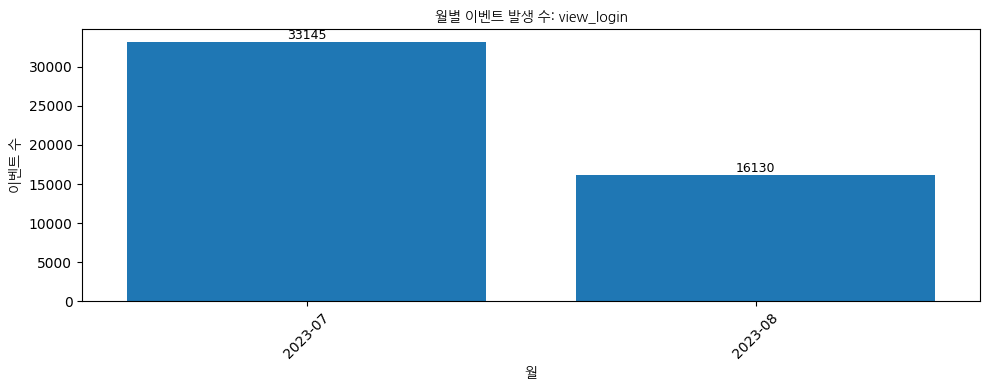

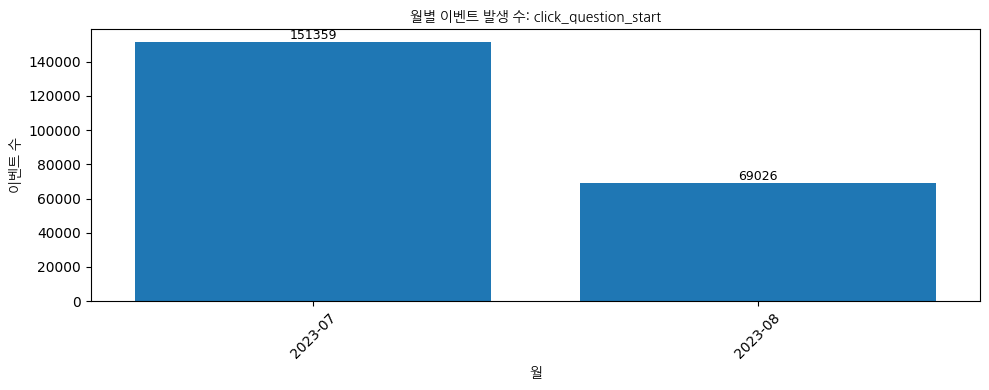

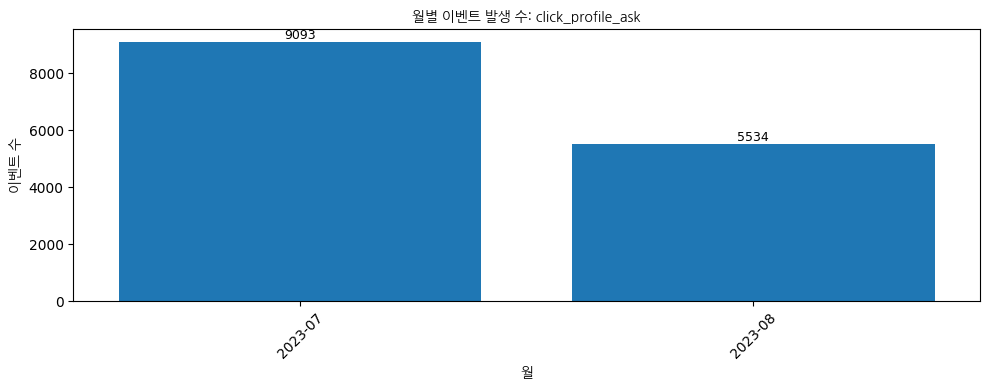

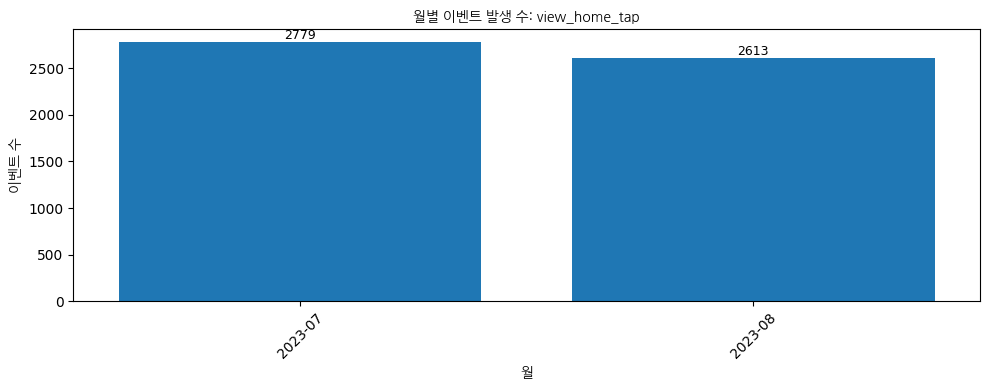

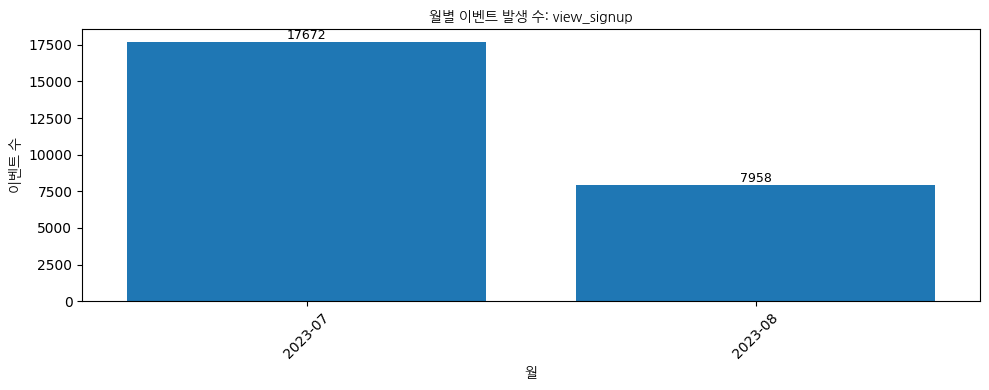

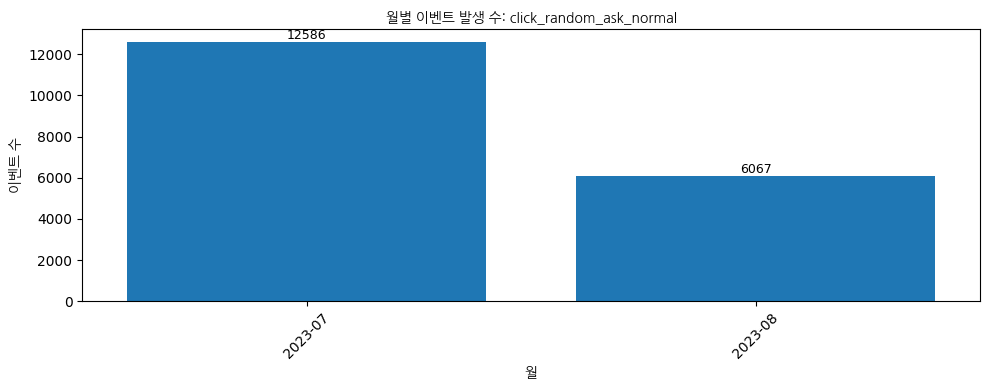

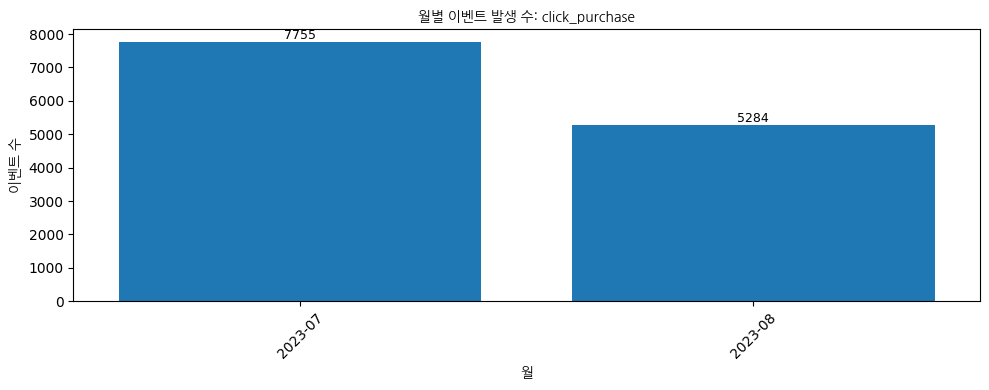

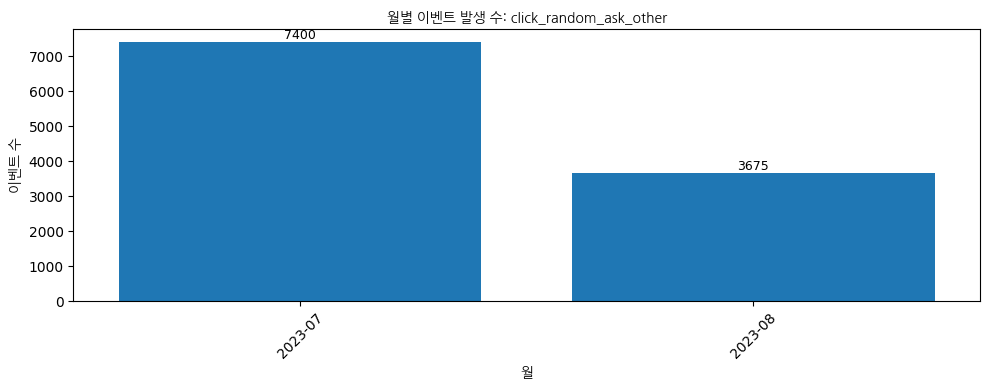

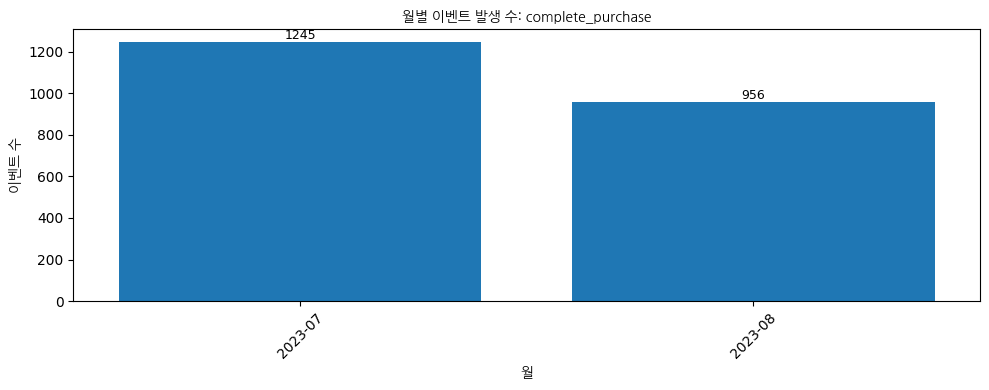

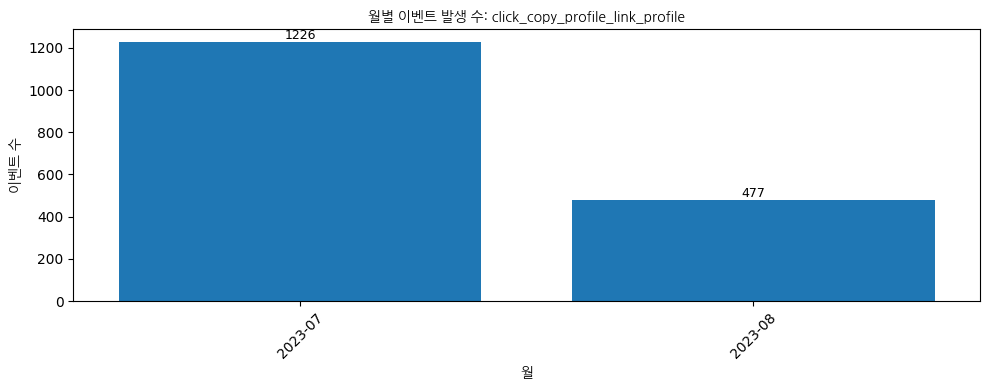

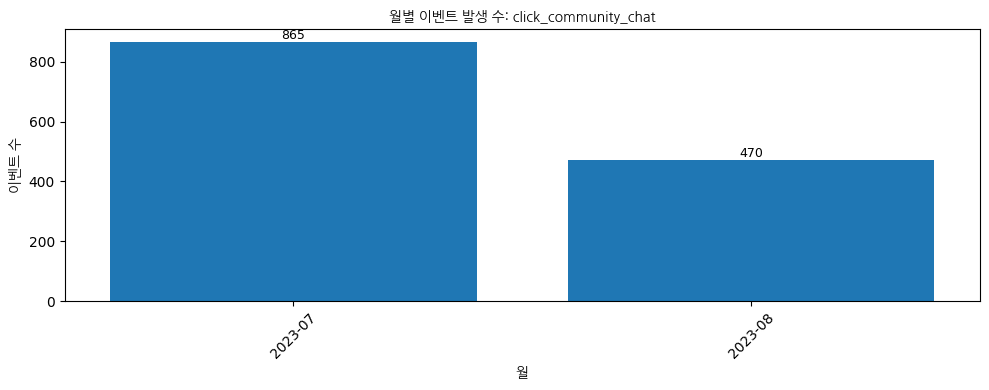

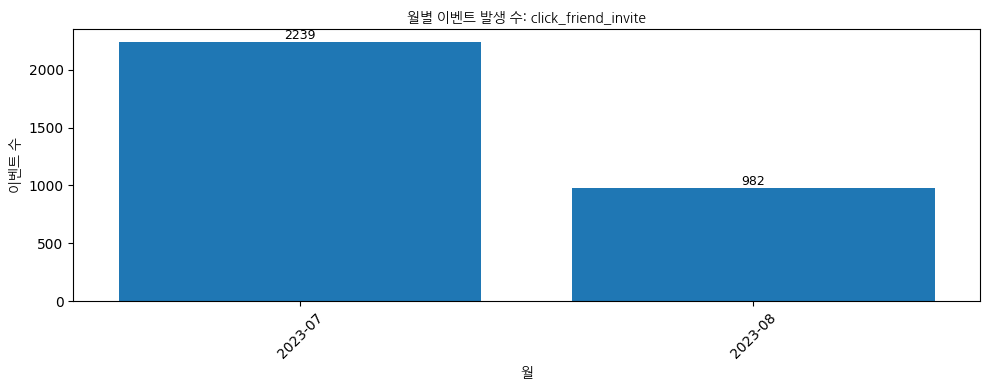

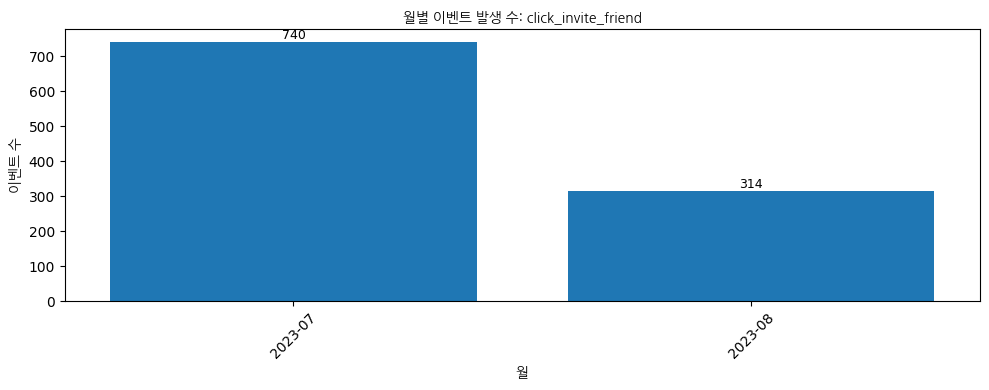

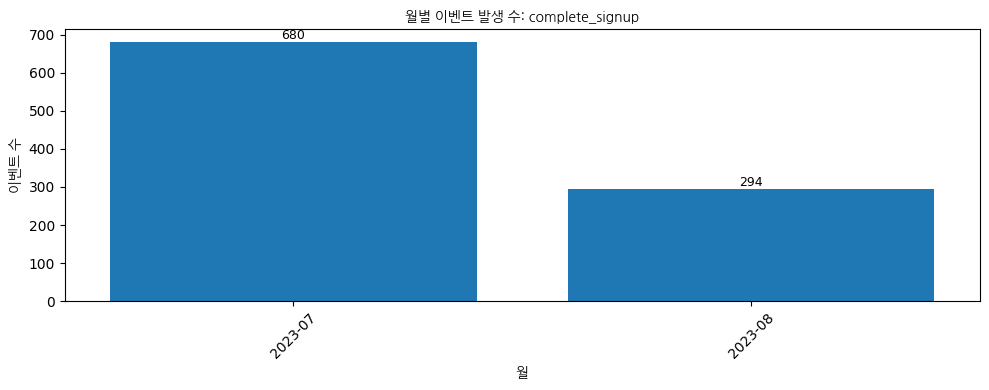

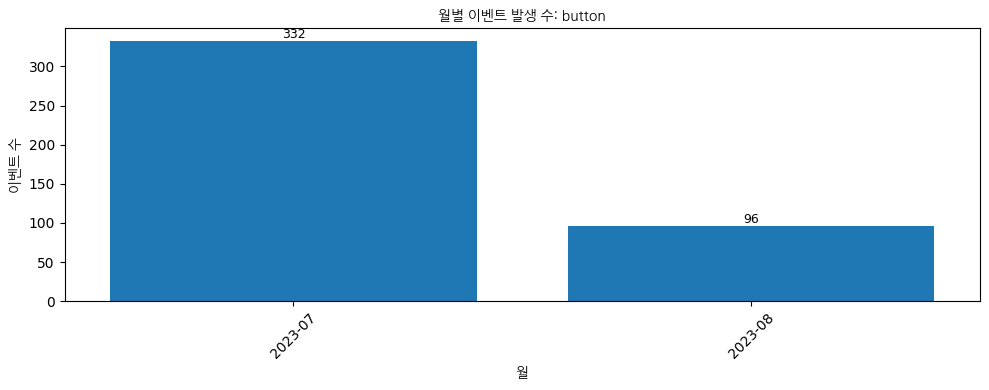

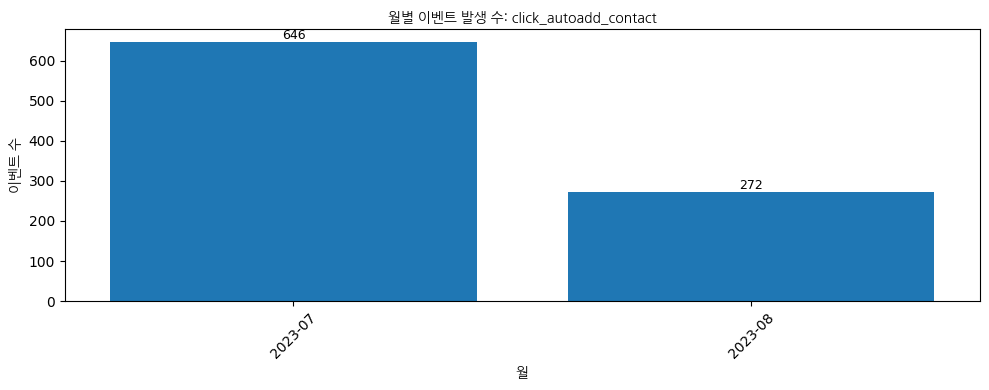

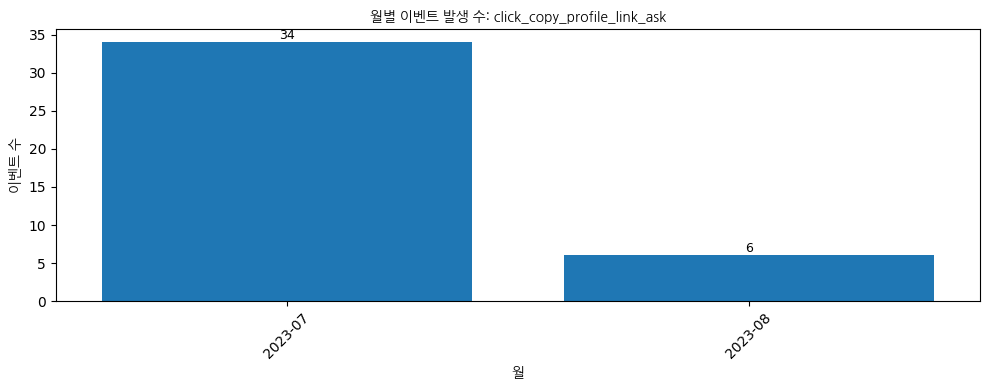

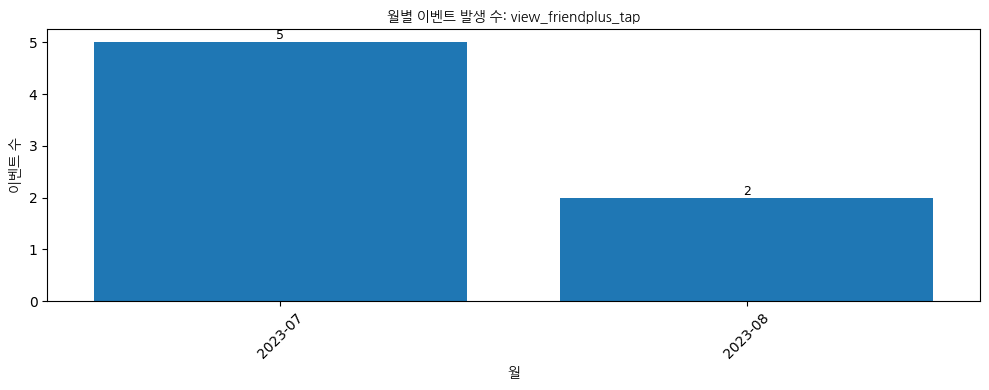

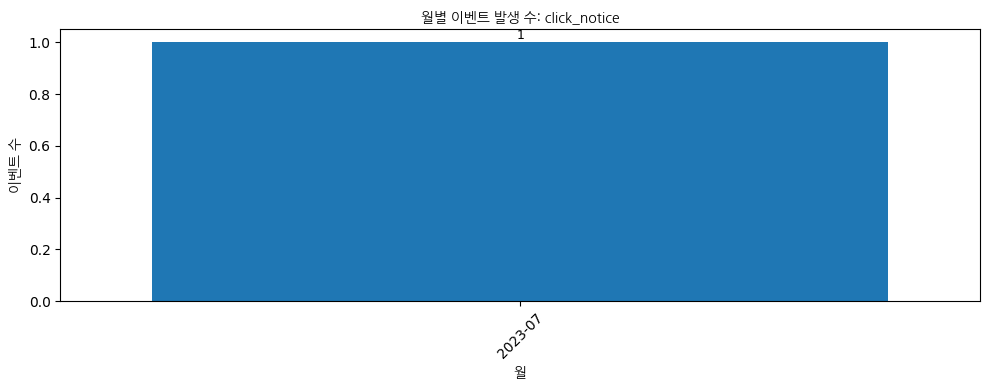

In [68]:
font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_prop = fm.FontProperties(fname=font_path)
# , fontproperties=font_prop

# datetime 형식 변환
hackle_events['event_datetime'] = pd.to_datetime(hackle_events['event_datetime'])

# 'year-month' 단위로 추출
hackle_events['year_month'] = hackle_events['event_datetime'].dt.to_period('M')

# 유니크한 이벤트 키 가져오기
event_keys = hackle_events['event_key'].unique()

# 결과 저장 딕셔너리
event_counts_by_month = {}

# 각 이벤트 키에 대해 월별 수 세기
for key in event_keys:
    filtered = hackle_events[hackle_events['event_key'] == key]
    monthly_counts = filtered.groupby('year_month').size()
    event_counts_by_month[key] = monthly_counts
    
    # 그래프 그리기
    plt.figure(figsize=(10, 4))
    monthly_counts.plot(kind='bar')
    bars = plt.bar(monthly_counts.index.astype(str), monthly_counts.values)
    plt.title(f"월별 이벤트 발생 수: {key}", fontproperties=font_prop)
    plt.xlabel("월", fontproperties=font_prop)
    plt.ylabel("이벤트 수", fontproperties=font_prop)
    plt.xticks(rotation=45)
    
    # 막대 위에 수치 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f"{int(height)}",
            ha='center',
            va='bottom',
            fontsize=9
        )
    plt.tight_layout()
    plt.show()


/tmp/ipykernel_722/901182188.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_count_by_friend_bin = hackle_events.groupby('friend_count_bin').size()


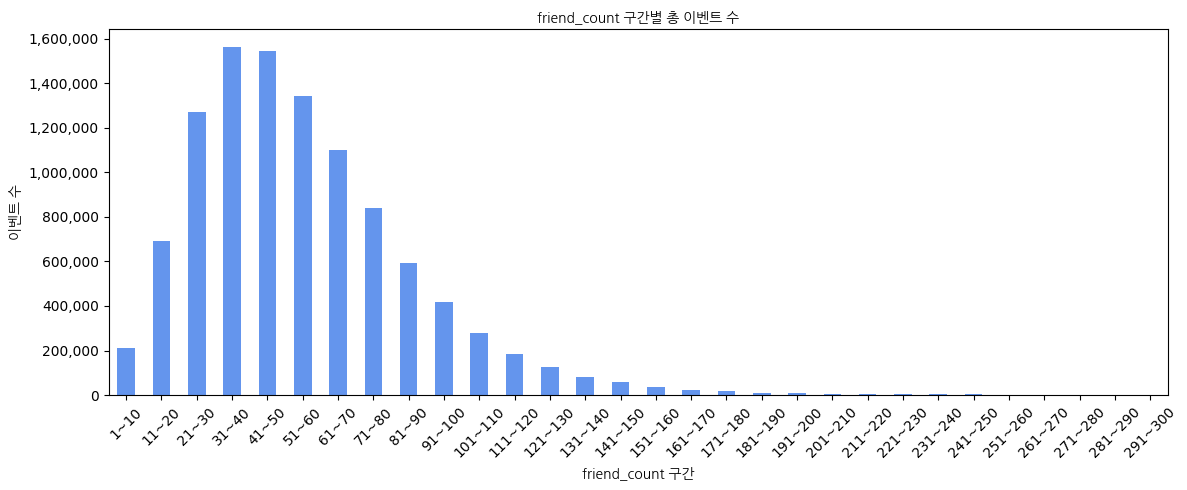

In [69]:
# 1. friend_count 구간 만들기 (10 단위로 binning)
hackle_events['friend_count'] = hackle_events['friend_count'].fillna(0).astype(int)
bins = range(0, 301, 10)  # 0, 10, 20, ..., 300
labels = [f"{i+1}~{i+10}" for i in bins[:-1]]  # ["1~10", "11~20", ..., "291~300"]
hackle_events['friend_count_bin'] = pd.cut(hackle_events['friend_count'], bins=bins, labels=labels, right=True)

# 2. friend_count 구간별 event 수 세기
event_count_by_friend_bin = hackle_events.groupby('friend_count_bin').size()

# 3. y축 숫자를 정수로 포맷하는 함수
def format_int(x, pos):
    return f"{int(x):,}"  # 천 단위 콤마 포함 정수

# 4. 시각화
plt.figure(figsize=(12, 5))
event_count_by_friend_bin.plot(kind='bar', color='cornflowerblue')
plt.title("friend_count 구간별 총 이벤트 수", fontproperties=font_prop)
plt.xlabel("friend_count 구간", fontproperties=font_prop)
plt.ylabel("이벤트 수", fontproperties=font_prop)
plt.xticks(rotation=45)

# y축 정수 포맷 적용
plt.gca().yaxis.set_major_formatter(FuncFormatter(format_int))

plt.tight_layout()
plt.show()

/tmp/ipykernel_722/2065551741.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('friend_count_bin')['session_id_encoded']


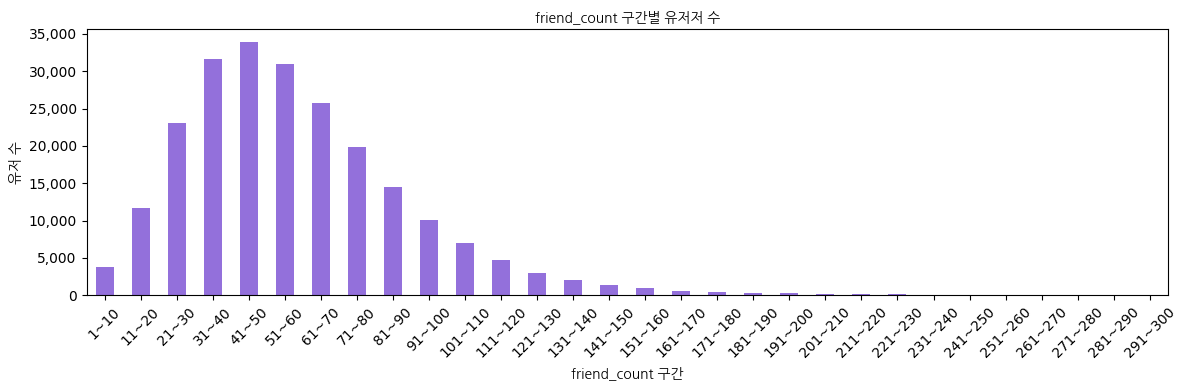

In [70]:
# friend_count_bin 별 고유 session_id_encoded 수 세기
session_count_by_bin = (
    hackle_events
    .groupby('friend_count_bin')['session_id_encoded']
    .nunique()
    .reindex(labels)  # 오름차순 정렬 유지
)



plt.figure(figsize=(12, 4))
session_count_by_bin.plot(kind='bar', color='mediumpurple')
plt.title("friend_count 구간별 유저저 수", fontproperties=font_prop)
plt.xlabel("friend_count 구간", fontproperties=font_prop)
plt.ylabel("유저 수", fontproperties=font_prop)
plt.xticks(rotation=45)
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{int(x):,}"))
plt.tight_layout()
plt.show()

In [71]:
# 3. 각 구간별 상위 10개 event_key 추출
top_event_keys_by_bin = {}

for bin_label in labels:  # 오름차순 순서대로 순회
    subset = hackle_events[hackle_events['friend_count_bin'] == bin_label]
    top_events = subset['event_key'].value_counts().head(10)
    top_event_keys_by_bin[bin_label] = top_events

# 4. 구간별로 출력
for bin_label, top_events in top_event_keys_by_bin.items():
    print(f"friend_count 구간: {bin_label}")
    print(top_events)
    print("-" * 40)

# 5. DataFrame 변환 및 friend_count_bin 컬럼 오름차순 정렬
result_df = pd.concat(top_event_keys_by_bin, axis=1)
result_df.columns.name = "friend_count_bin"
result_df = result_df[labels]  #  컬럼 순서 정렬

# 6. 결과 출력
display(result_df)

friend_count 구간: 1~10
event_key
view_lab_tap                         26621
view_timeline_tap                    25563
click_bottom_navigation_questions    14983
click_bottom_navigation_profile      14554
launch_app                           13307
click_question_open                  12999
skip_question                        12081
$session_start                       11603
click_bottom_navigation_timeline     11034
view_profile_tap                      9421
Name: count, dtype: int64
----------------------------------------
friend_count 구간: 11~20
event_key
view_lab_tap                         79288
view_timeline_tap                    76932
click_question_open                  52227
launch_app                           50121
click_bottom_navigation_questions    46346
$session_start                       43151
click_bottom_navigation_profile      41673
skip_question                        39944
click_bottom_navigation_timeline     33156
$session_end                         32547
Name: co

friend_count_bin                      1~10    11~20     21~30     31~40     41~50     51~60     61~70     71~80    81~90   91~100  101~110  111~120  121~130  131~140  141~150  151~160  161~170  171~180  181~190  191~200  201~210  211~220  221~230  231~240  241~250  251~260  261~270  271~280  281~290  291~300
event_key                                                                                                                                                                                                                                                                                                            
view_lab_tap                       26621.0  79288.0  144821.0  183143.0  184278.0  162654.0  132708.0  101236.0  71426.0  49600.0  33200.0  22332.0  14760.0   9809.0   6395.0   4137.0   2658.0   2022.0   1009.0   1218.0    825.0    500.0    472.0    425.0    376.0    123.0    144.0     97.0     85.0     71.0
view_timeline_tap                  25563.0  76932.0  138712.0  175337.0  175580.0  153938.0  125426.0   94812.0  66782.0  46636.0  30741.0  20563.0  13488.0   8723.0   5899.0   3933.0   2385.0   1830.0    882.0   1049.0    719.0    466.0    421.0    345.0    311.0     87.0    128.0     95.0     70.0     77.0
click_bottom_navigation_questions  14983.0  46346.0   86102.0  112308.0  112534.0  101441.0   81580.0   61884.0  44092.0  30344.0  20595.0  13437.0   8751.0   5578.0   3929.0   2469.0   1517.0   1140.0    649.0    608.0    499.0    306.0    297.0    233.0    199.0     81.0     92.0     57.0     51.0     50.0
click_bottom_navigation_profile    14554.0  41673.0   75084.0   93869.0   94516.0   83909.0   67794.0   51759.0  36799.0  25184.0  17201.0  11340.0   7739.0   5206.0   3336.0   2120.0   1416.0   1069.0    549.0    538.0    416.0    242.0    250.0    229.0    185.0     68.0     76.0     50.0     47.0     35.0
launch_app                         13307.0  50121.0   94318.0  112557.0  110663.0   98260.0   78821.0   60953.0  45161.0  31356.0  21898.0  14480.0  10276.0   6517.0   4671.0   3149.0   1841.0   1410.0    746.0    860.0    464.0    335.0    434.0    438.0    224.0    108.0     86.0     68.0     57.0     80.0
click_question_open                12999.0  52227.0   98660.0  117004.0  114497.0  100355.0   83451.0   63121.0  45467.0  32975.0  22127.0  14065.0   9380.0   6464.0   4622.0   2895.0   1754.0   1405.0    694.0    791.0    571.0    262.0    453.0    163.0    194.0     91.0      NaN     64.0    104.0    114.0
skip_question                      12081.0  39944.0   75129.0   72951.0       NaN       NaN       NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN   3343.0      NaN      NaN      NaN      NaN      NaN      NaN      NaN    318.0      NaN    163.0      NaN      NaN      NaN      NaN      NaN
$session_start                     11603.0  43151.0   81831.0  101319.0   99733.0   88085.0   71646.0   55059.0  40522.0  28502.0  19819.0  12835.0   8967.0   5840.0   4114.0   2719.0   1638.0   1299.0    680.0    705.0    420.0    307.0    400.0    339.0    183.0     92.0     82.0     63.0     52.0     79.0
click_bottom_navigation_timeline   11034.0  33156.0   60369.0   79312.0   78245.0   71153.0   56479.0   42700.0  30632.0  21296.0  13973.0   9363.0   6359.0   3853.0   2649.0   1814.0   1065.0    839.0    415.0    473.0    338.0    212.0      NaN      NaN    137.0     46.0     64.0     65.0     30.0     39.0
view_profile_tap                    9421.0      NaN       NaN       NaN       NaN       NaN       NaN       NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN      NaN     54.0      NaN      NaN      NaN
$session_end                           NaN  32547.0   60194.0   71740.0   67382.0   58333.0   46253.0   35463.0  25778.0  18215.0  12599.0   7996.0   5899.0   3703.0   2699.0   1773.0   1051.0    832.0    422.0    460.0      NaN    158.0    273.0    270.0      NaN     58.0     51

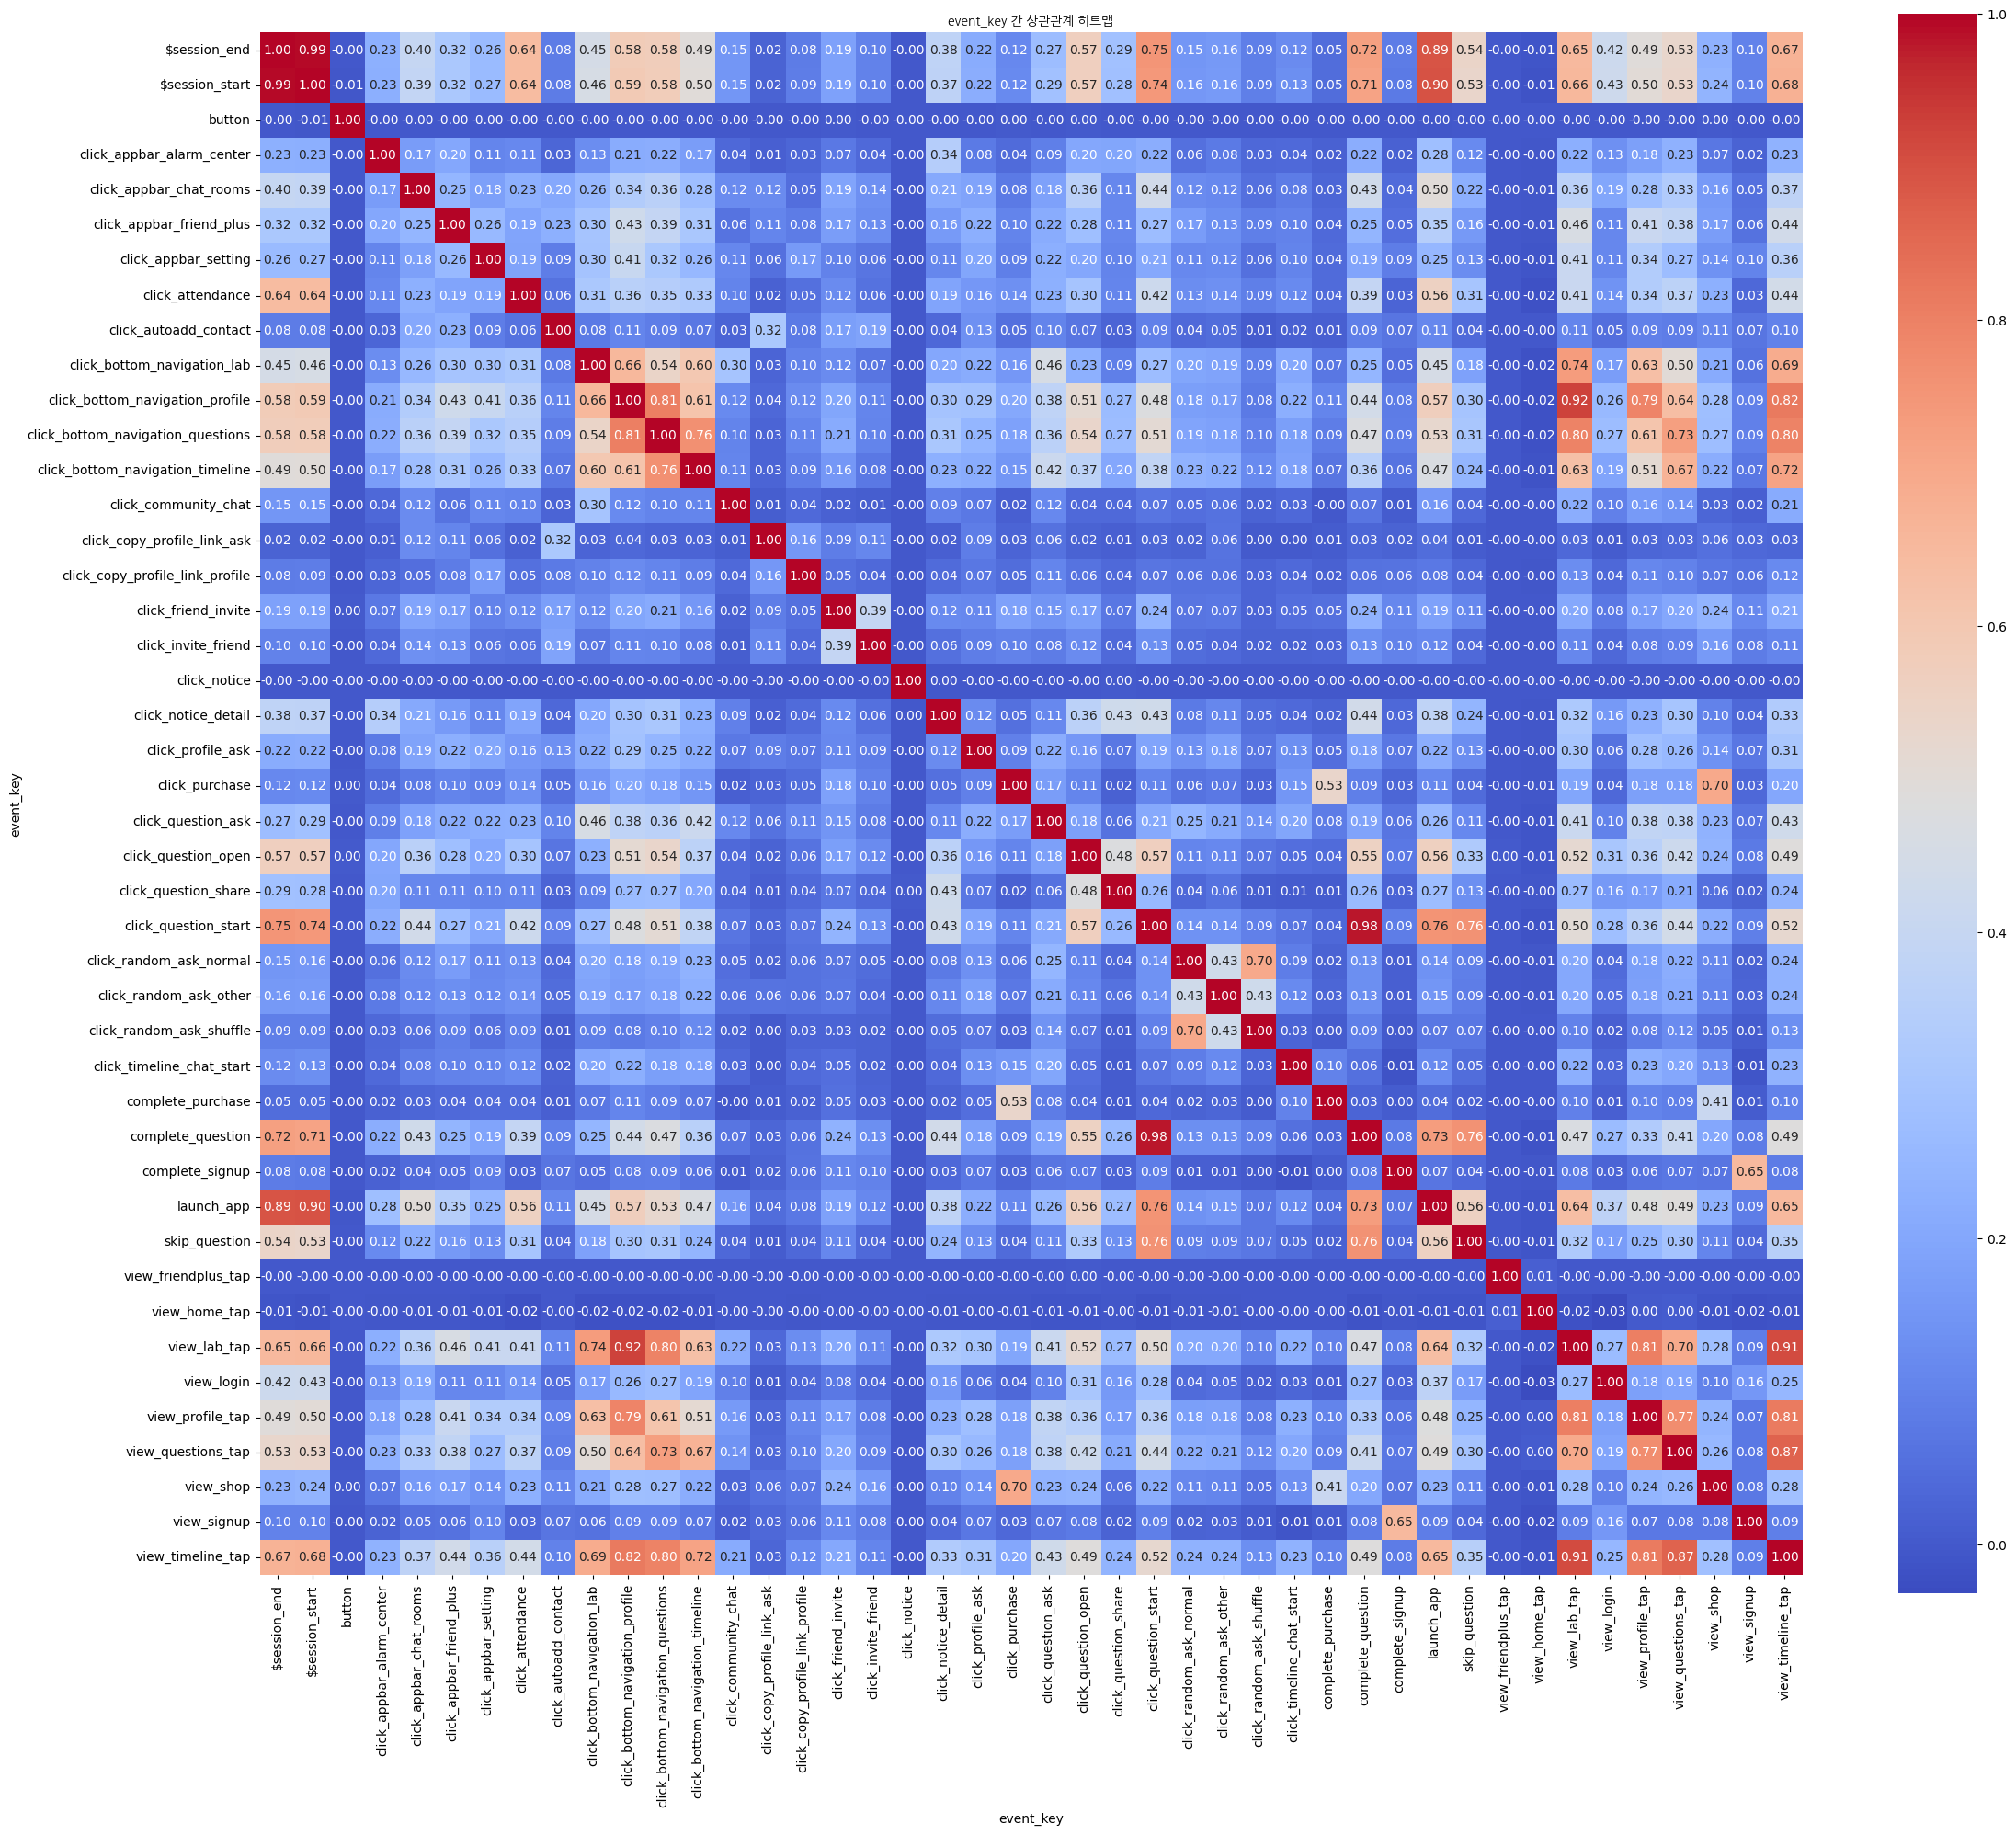

In [72]:
# 1. session_id_encoded별 event_key 발생 횟수 집계 (피벗테이블 형태)
event_pivot = (
    hackle_events
    .groupby(['session_id_encoded', 'event_key'])
    .size()
    .unstack(fill_value=0)
)

# 2. 상관관계 행렬 계산 (Pandas corr 함수)
correlation_matrix = event_pivot.corr()

# 3. 시각화 (히트맵)
plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("event_key 간 상관관계 히트맵", fontproperties=font_prop)
plt.tight_layout()
plt.show()


### 연속성 기반 연관규칙 분석	mlxtend 사용 → Association Rules (Apriori/FP-Growth)	A 이벤트를 수행한 유저가 B 이벤트도 자주 하는가

In [73]:
# # 1. 세션 수 제한 (5000개 샘플링)
# sample_sessions = hackle_events['session_id_encoded'].drop_duplicates().sample(5000, random_state=42)
# sample_df = hackle_events[hackle_events['session_id_encoded'].isin(sample_sessions)]

# # 2. 세션별 event_key 리스트 추출
# event_baskets = (
#     sample_df.groupby('session_id_encoded')['event_key']
#     .apply(list)
#     .tolist()
# )

# # 3. TransactionEncoder로 one-hot encoding
# te = TransactionEncoder()
# te_ary = te.fit(event_baskets).transform(event_baskets)
# df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# # 4. apriori 적용 (최소 지지도 1%로 설정)
# frequent_itemsets = apriori(df_encoded, min_support=0.01, use_colnames=True)

# # 5. 연관 규칙 도출
# rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# # 6. 결과 확인 (상위 10개)
# rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)


In [74]:
# 월별 회원가입 수
hackle_events[hackle_events['event_key'] == 'complete_signup'].year_month.value_counts()

year_month
2023-07    680
2023-08    294
Freq: M, Name: count, dtype: int64

In [75]:
# 기존 유저 수
hackle_events.session_id_encoded.nunique()

253616

In [76]:
# 1. 'complete_signup' 발생 세션의 year_month 추출 (중복 제거)
signup_df = (
    hackle_events[hackle_events['event_key'] == 'complete_signup'][['session_id_encoded', 'year_month']]
    .drop_duplicates(subset='session_id_encoded')  # ✅ 고유 세션만 남기기
)

# 2. session_id_encoded → year_month 매핑 생성
session_to_month = signup_df.set_index('session_id_encoded')['year_month']

# 3. 전체 데이터에서 complete_signup 발생 세션만 필터링
filtered_df = hackle_events[hackle_events['session_id_encoded'].isin(session_to_month.index)].copy()

# 4. 각 세션의 가입 월 매핑
filtered_df['signup_month'] = filtered_df['session_id_encoded'].map(session_to_month)

# 5. signup_month별 전체 event 수 세기
event_count_by_signup_month = (
    filtered_df
    .groupby('signup_month')
    .size()
    .sort_index()
)

# 6. 결과 확인
event_count_by_signup_month


signup_month
2023-07    181810
2023-08     26036
Freq: M, dtype: int64

In [77]:
hackle_events.head(1)

event_datetime       event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin
0 2023-07-18 19:40:17  $session_start                                 0          NaN            NaN          NaN               31497    2023-07              NaN

In [78]:
# 1. complete_signup 세션 목록 만들기
signup_df = (
    hackle_events[hackle_events['event_key'] == 'complete_signup'][['session_id_encoded', 'year_month']]
    .drop_duplicates(subset='session_id_encoded')
)

# 2. signup 그룹 지정 함수
def classify_signup_group(month):
    if month == '2023-07':
        return 'signup_2023_07'
    elif month == '2023-08':
        return 'signup_2023_08'
    else:
        return 'others'

signup_df['signup_group'] = signup_df['year_month'].astype(str).apply(classify_signup_group)

# 3. 모든 세션에 signup_group을 붙이기 (없는 경우 others 처리)
session_to_group = signup_df.set_index('session_id_encoded')['signup_group']
hackle_events['signup_group'] = hackle_events['session_id_encoded'].map(session_to_group).fillna('others')

# 4. question이 포함된 이벤트만 필터링
question_events = hackle_events[hackle_events['event_key'].str.contains("question", case=False, na=False)].copy()
question_events['year_month'] = question_events['year_month'].astype(str)

# 5. ✅ signup_group + year_month + event_key별 개수 집계
summary = (
    question_events
    .groupby(['signup_group', 'year_month', 'event_key'])
    .size()
    .unstack(fill_value=0)   # event_key를 컬럼으로
    .reset_index()           # index 펼치기
    .sort_values(by=['signup_group', 'year_month'])  # 보기 좋게 정렬
)

# 6. 결과 확인
display(summary)


event_key    signup_group year_month  click_bottom_navigation_questions  click_question_ask  click_question_open  click_question_share  click_question_start  complete_question  skip_question  view_questions_tap
0                  others    2023-07                             510258               90402               531496                 50747                145845             102848         294859              154157
1                  others    2023-08                             246053               44556               265901                 16395                 67215              45630         146492              193325
2          signup_2023_07    2023-07                               9927                1378                16123                  1807                  5476               4248           9905                3249
3          signup_2023_07    2023-08                               1283                 101                 2717                   239                  1360               1052           2368                1220
4          signup_2023_08    2023-07                                 54                   2                   42                     1                    38                 31            293                  14
5          signup_2023_08    2023-08                               1588                 327                  522                    52                   451                296           1064                1435

In [79]:
hackle_events.head(1)

event_datetime       event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin signup_group
0 2023-07-18 19:40:17  $session_start                                 0          NaN            NaN          NaN               31497    2023-07              NaN       others

In [80]:
# 1. 2023년 8월에 complete_signup한 세션ID들 추출
aug_signup_sessions = hackle_events[
    (hackle_events['event_key'] == 'complete_signup') &
    (hackle_events['year_month'] == '2023-08')
]['session_id_encoded'].unique()

# 2. 그 중에서 2023-07에도 존재한 세션 필터링
july_logs = hackle_events[
    (hackle_events['year_month'] == '2023-07') &
    (hackle_events['session_id_encoded'].isin(aug_signup_sessions))
]

# 3. 결과: 2023년 8월에 가입했고, 7월에도 활동한 세션 목록
sessions_with_prior_logs = july_logs['session_id_encoded'].unique()

# 4. 필요한 경우 해당 세션 전체 로그 추출
result_df = hackle_events[hackle_events['session_id_encoded'].isin(sessions_with_prior_logs)]

# 5. 확인
print(f"2023년 8월에 가입했으나 7월에도 활동한 세션 수: {len(sessions_with_prior_logs)}")
display(result_df.head())


2023년 8월에 가입했으나 7월에도 활동한 세션 수: 23


event_datetime                          event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
124  2023-08-02 10:33:00                  view_timeline_tap                               116         73.0          182.0          NaN               75082    2023-08          111~120  signup_2023_08
1764 2023-07-30 16:55:12                      skip_question                               116         73.0          182.0        487.0               75082    2023-07          111~120  signup_2023_08
2649 2023-08-04 17:41:31  click_bottom_navigation_questions                                 0          0.0          300.0          NaN              243090    2023-08              NaN  signup_2023_08
3893 2023-08-07 18:47:17                  complete_question                                 0          0.0          300.0          NaN               25791    2023-08              NaN  signup_2023_08
7487 2023-08-06 05:09:21        click_bottom_navigation_lab                               116         73.0          182.0          NaN               75082    2023-08          111~120  signup_2023_08

In [81]:
len(result_df)

3246

In [82]:
result_df.session_id_encoded.nunique()

23

In [83]:
what_the_hell = result_df[result_df['session_id_encoded'] == 75082].sort_values(by='event_datetime', ascending=True)
what_the_hell.head()

event_datetime       event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
2042818  2023-07-19 00:34:07  $session_start                               115         73.0          175.0          NaN               75082    2023-07          111~120  signup_2023_08
6666650  2023-07-19 00:34:24     view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
6318201  2023-07-19 00:34:28     view_signup                 반선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
10258460 2023-07-19 00:35:09     view_signup                번호인증             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
300220   2023-07-19 00:35:25     view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08

In [84]:
len(what_the_hell)

1997

In [85]:
what_the_hell[what_the_hell['event_key'] == 'complete_signup']

event_datetime        event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
4767679 2023-07-19 01:06:22  complete_signup                                 0          0.0          300.0          NaN               75082    2023-07              NaN  signup_2023_08
4485102 2023-08-07 19:58:55  complete_signup                                 0          0.0          300.0          NaN               75082    2023-08              NaN  signup_2023_08

In [86]:
what_the_hell

event_datetime                          event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
2042818  2023-07-19 00:34:07                     $session_start                               115         73.0          175.0          NaN               75082    2023-07          111~120  signup_2023_08
6666650  2023-07-19 00:34:24                        view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
6318201  2023-07-19 00:34:28                        view_signup                 반선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
10258460 2023-07-19 00:35:09                        view_signup                번호인증             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
300220   2023-07-19 00:35:25                        view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
8920324  2023-07-19 00:35:41                        view_signup                 반선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
10048952 2023-07-19 00:36:16                        view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
8337809  2023-07-19 00:36:17                        view_signup                학교선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
9142374  2023-07-19 00:36:22                        view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
4888774  2023-07-19 00:36:26                        view_signup                 반선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
5897445  2023-07-19 00:37:00                        view_signup                학년선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
3714498  2023-07-19 00:37:02                        view_signup                 반선택             0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
5073741  2023-07-19 00:37:15                       $session_end                                 0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
10643    2023-07-19 00:37:15                         view_login                                 0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
8426248  2023-07-19 00:37:20                     $session_start                                 0          NaN            NaN          NaN               75082    2023-07              NaN  signup_2023_08
2251888  2023-07-19 00:37:22                       view_lab_tap                               115         73.0          175.0          NaN               75082    2023-07          111~120  signup_2023_08
4241046  2023-07-19 00:37:22    click_bottom_navigation_profile                               115         73.0          175.0          NaN               75082    2023-07          111~120  signup_2023_08
1941769  2023-07-19 00:37:24  click_bottom_navigation_questions                               115         73.0          175.0          NaN               75082    2023-07          111~120  signup_2023_08
697063   2023-07-19 00:37:24               click_question_start                home           115         73.0          175.0          NaN               7508

In [87]:
# 243090
what_the_hell_2 = hackle_events[hackle_events['session_id_encoded'] == 243090].sort_values(by='event_datetime', ascending=True)
what_the_hell_2.head()

event_datetime                event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
3513413  2023-07-28 15:35:51               launch_app                               107        175.0           12.0          NaN              243090    2023-07          101~110  signup_2023_08
425632   2023-07-28 15:35:51           $session_start                               107        175.0           12.0          NaN              243090    2023-07          101~110  signup_2023_08
2885862  2023-08-01 18:34:09           $session_start                               107        175.0           12.0          NaN              243090    2023-08          101~110  signup_2023_08
6037508  2023-08-01 18:34:09               launch_app                               107        175.0           12.0          NaN              243090    2023-08          101~110  signup_2023_08
10702383 2023-08-01 18:35:31  click_appbar_chat_rooms                               107        175.0           12.0          NaN              243090    2023-08          101~110  signup_2023_08

In [88]:
what_the_hell_2[what_the_hell_2['event_key'] == 'complete_signup']


event_datetime        event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
478573 2023-08-04 17:40:44  complete_signup                                 0          0.0          300.0          NaN              243090    2023-08              NaN  signup_2023_08

In [89]:
crazy = result_df[result_df['event_key'] == 'complete_signup']
crazy.head()

event_datetime        event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
273449  2023-08-05 20:21:13  complete_signup                                 0          0.0          300.0          NaN                6863    2023-08              NaN  signup_2023_08
478573  2023-08-04 17:40:44  complete_signup                                 0          0.0          300.0          NaN              243090    2023-08              NaN  signup_2023_08
500038  2023-08-06 13:04:36  complete_signup                                 0          0.0          300.0          NaN               50803    2023-08              NaN  signup_2023_08
1466577 2023-08-05 20:10:45  complete_signup                                 0          0.0          300.0          NaN               10203    2023-08              NaN  signup_2023_08
2127094 2023-08-07 20:42:02  complete_signup                                 0          0.0          300.0          NaN              144490    2023-08              NaN  signup_2023_08

In [90]:
crazy.groupby('session_id_encoded').size().sort_values(ascending=False)

session_id_encoded
75082     2
6863      1
5428      1
25791     1
43758     1
50803     1
10203     1
54668     1
68775     1
69052     1
76170     1
79365     1
79670     1
83432     1
95119     1
118389    1
144490    1
160793    1
170644    1
175180    1
187699    1
211911    1
243090    1
dtype: int64

In [91]:
result_df[result_df['session_id_encoded'] == 68775].sort_values(by='event_datetime', ascending=True)

event_datetime        event_key item_name page_name  friend_count  votes_count  heart_balance  question_id  session_id_encoded year_month friend_count_bin    signup_group
10115265 2023-07-19 13:05:12       launch_app                                 0          NaN            NaN          NaN               68775    2023-07              NaN  signup_2023_08
10473694 2023-07-19 13:05:12   $session_start                                 0          NaN            NaN          NaN               68775    2023-07              NaN  signup_2023_08
5235276  2023-08-07 08:29:11       launch_app                                 0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
8087958  2023-08-07 08:29:11   $session_start                                 0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
10523797 2023-08-07 08:29:57      view_signup                학년선택             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
5023141  2023-08-07 08:30:00      view_signup                 반선택             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
3866517  2023-08-07 08:30:11      view_signup                번호인증             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
8382389  2023-08-07 08:30:24      view_signup               아이디입력             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
8341798  2023-08-07 08:30:26      view_signup                성별선택             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
2043464  2023-08-07 08:30:27      view_signup                프사설정             0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
2293275  2023-08-07 08:30:27     $session_end                                 0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
9353903  2023-08-07 08:30:32   $session_start                                 0          NaN            NaN          NaN               68775    2023-08              NaN  signup_2023_08
9617357  2023-08-07 08:30:32  complete_signup                                 0          0.0          300.0          NaN               68775    2023-08              NaN  signup_2023_08

In [92]:
what_the_hell.event_key.value_counts()

event_key
skip_question                        662
view_lab_tap                         221
view_timeline_tap                    180
click_bottom_navigation_profile      133
launch_app                            92
$session_start                        79
click_bottom_navigation_questions     78
$session_end                          78
click_question_start                  75
view_profile_tap                      71
complete_question                     67
click_bottom_navigation_timeline      45
click_bottom_navigation_lab           42
click_question_open                   41
view_questions_tap                    37
view_signup                           27
click_appbar_setting                  15
click_attendance                      11
view_login                             6
click_appbar_chat_rooms                6
click_notice_detail                    6
click_random_ask_shuffle               5
click_appbar_alarm_center              5
click_appbar_friend_plus               5
comple

In [93]:
len(what_the_hell.event_key.unique())

32

In [94]:
len(hackle_events.event_key.unique())

44